In [22]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)
    
import numpy as np
import pandas as pd
import skforecast

print(skforecast.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/joaquin/Documents/GitHub/skforecast
0.20.0


In [23]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import skforecast
from skforecast.stats import Sarimax, Arima
from skforecast.recursive import ForecasterStats
from skforecast.model_selection import TimeSeriesFold, backtesting_stats
from skforecast.plot import set_dark_theme
from skforecast.datasets import fetch_dataset

from aeon.forecasting.stats import ARIMA as ARIMA_aeon
from statsforecast import StatsForecast
from statsforecast.models import ARIMA as ARIMA_statsforecast
import matplotlib.pyplot as plt
import timeit

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
print(f"skforecast version: {skforecast.__version__}")

skforecast version: 0.20.0


# Fuel consumption dataset

In [24]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=True, verbose=False)
data = data[['Fecha', 'Gasolinas']]
data = data.rename(columns={'Fecha': 'date', 'Gasolinas': 'y'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.loc[:'1990-01-01 00:00:00', ['y']]
data['month'] = data.index.month
data = pd.get_dummies(data, columns=['month'], prefix='month', drop_first=False, dtype=float)
data.head(3)

,y,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
1969-01-01,166875.2129,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-02-01,155466.8105,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-03-01,184983.6699,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


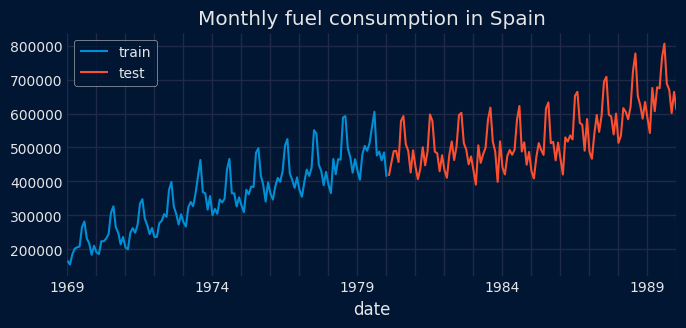

In [25]:
# Train-test dates
# ======================================================================================
set_dark_theme()
end_train = '1980-01-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

# Compare ets from skforecast, aeon, statsforecast and statsmodels

In [26]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1)
m = 12

In [27]:
# ARIMA skforecast
# ==============================================================================
forecaster = ForecasterStats(
                estimator = Arima(
                    order=order,
                    seasonal_order=seasonal_order,
                    m = m
                )
            )
start = timeit.default_timer()
forecaster.fit(y=data_train['y'])
end = timeit.default_timer()
time_fit_arima_skforecast = end - start
print(f"Training time ARIMA skforecast  : {time_fit_arima_skforecast} seconds")
start = timeit.default_timer()
predictions_skforecast = forecaster.predict(steps=24)
end = timeit.default_timer()
time_pred_arima_skforecast = end - start
prediction_intervals_skforecast = forecaster.predict_interval(steps=24, alpha=0.05)
print(f"Prediction time ARIMA skforecast: {time_pred_arima_skforecast} seconds")

Training time ARIMA skforecast  : 0.3258878899978299 seconds
Prediction time ARIMA skforecast: 0.0014030530001036823 seconds


/home/joaquin/Documents/GitHub/skforecast/skforecast/stats/arima/_arima_base.py:2476: UserWarning: Possible convergence problem
  warnings.warn("Possible convergence problem")


In [28]:
# ARIMA statsmodels
# ==============================================================================
seasonal_order_statsmodels = (
    seasonal_order[0],
    seasonal_order[1],
    seasonal_order[2],
    m if m > 1 else 0
)
forecaster = ForecasterStats(
                estimator = Sarimax(
                    order=order,
                    seasonal_order=seasonal_order_statsmodels
                )
            )
start = timeit.default_timer()
forecaster.fit(y=data_train['y'])
end = timeit.default_timer()
time_fit_arima_statsmodels = end - start
print(f"Training time ARIMA skforecast  : {time_fit_arima_statsmodels} seconds")
start = timeit.default_timer()
predictions_statsmodels = forecaster.predict(steps=24)
end = timeit.default_timer()
time_pred_arima_statsmodels = end - start
prediction_intervals_statsmodels = forecaster.predict_interval(steps=24, alpha=0.05)
print(f"Prediction time ARIMA skforecast: {time_pred_arima_statsmodels} seconds")

Training time ARIMA skforecast  : 0.6901825099994312 seconds
Prediction time ARIMA skforecast: 0.013714501001231838 seconds


In [29]:
# ARIMA aeon
# ==============================================================================
# Aeeon ARIMA do not support seasonality nor prediction intervals
forecaster = ForecasterStats(
                 estimator=ARIMA_aeon(p=order[0], d=order[1], q=order[2])   
             )
start = timeit.default_timer()
forecaster.fit(y=data_train['y'])
end = timeit.default_timer()
time_fit_arima_aeon = end - start
print(f"Training time ARIMA aeon  : {time_fit_arima_aeon} seconds")
start = timeit.default_timer()
predictions_aeon = forecaster.predict(steps=24)
end = timeit.default_timer()
time_pred_arima_aeon = end - start
print(f"Prediction time ARIMA aeon: {time_pred_arima_aeon} seconds")

Training time ARIMA aeon  : 0.002163986002415186 seconds
Prediction time ARIMA aeon: 0.0016728430018702056 seconds


In [30]:
# Nixtla StatsForecast Arima
# ==============================================================================
df_nixtla = data_train['y'].reset_index()
df_nixtla.columns = ['ds', 'y']
df_nixtla['unique_id'] = 'fuel'

start = timeit.default_timer()
sf = StatsForecast(
    models=[ARIMA_statsforecast(order=order, seasonal_order=seasonal_order, season_length=m)],
    freq='MS'
)
sf.fit(df=df_nixtla)
end = timeit.default_timer()
time_fit_arima_nixtla = end - start
print(f"Training time ARIMA nixtla  : {time_fit_arima_nixtla} seconds")

start = timeit.default_timer()
predictions_nixtla_df = sf.predict(h=24, level=[95])
end = timeit.default_timer()
time_pred_arima_nixtla = end - start

# Extract predictions and prediction intervals
predictions_nixtla = predictions_nixtla_df['ARIMA'].values
predictions_nixtla = pd.Series(predictions_nixtla, index=pd.date_range(start=data_test.index[0], periods=24, freq='MS'))

prediction_intervals_nixtla = pd.DataFrame({
    'lower_bound': predictions_nixtla_df['ARIMA-lo-95'].values,
    'upper_bound': predictions_nixtla_df['ARIMA-hi-95'].values
}, index=predictions_nixtla.index)

print(f"Prediction time ARIMA nixtla: {time_pred_arima_nixtla} seconds")

Training time ARIMA nixtla  : 0.0950624120014254 seconds
Prediction time ARIMA nixtla: 0.0073601090007286984 seconds


In [31]:
# Table of times
# ==============================================================================
times_arima = pd.DataFrame({
    'fit_time_seconds': [time_fit_arima_skforecast, time_fit_arima_aeon, time_fit_arima_nixtla, time_fit_arima_statsmodels],
    'predict_time_seconds': [time_pred_arima_skforecast, time_pred_arima_aeon, time_pred_arima_nixtla, time_pred_arima_statsmodels]
}, index=['ARIMA skforecast', 'ARIMA aeon', 'ARIMA nixtla', 'ARIMA statsmodels'])
times_arima.sort_values(by='fit_time_seconds')

,fit_time_seconds,predict_time_seconds
ARIMA aeon,0.002164,0.001673
ARIMA nixtla,0.095062,0.007360
ARIMA skforecast,0.325888,0.001403
ARIMA statsmodels,0.690183,0.013715


,skforecast,aeon,nixtla,statsmodels
1980-02-01,399331.423453,433252.910649,423427.567783,407504.056939
1980-03-01,470060.762792,445437.189745,484900.781143,473997.245807
1980-04-01,486735.887566,453102.772854,486345.138030,489983.091486


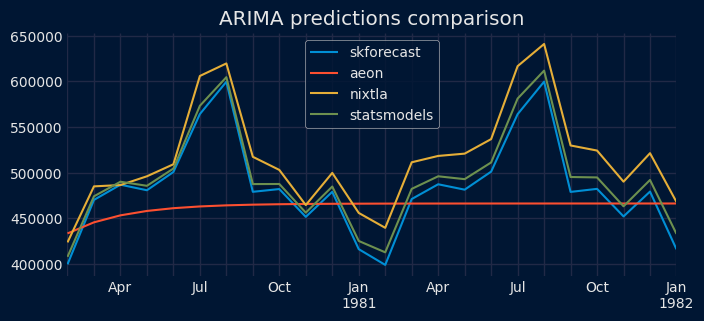

In [34]:
# compare predictions
# ======================================================================================
predictions = pd.DataFrame({
    'skforecast': predictions_skforecast,
    'aeon'      : predictions_aeon,
    'nixtla'    : predictions_nixtla,
    'statsmodels': predictions_statsmodels
})
display(predictions.head(3))
predictions.plot(figsize=(7, 3), title='ARIMA predictions comparison');

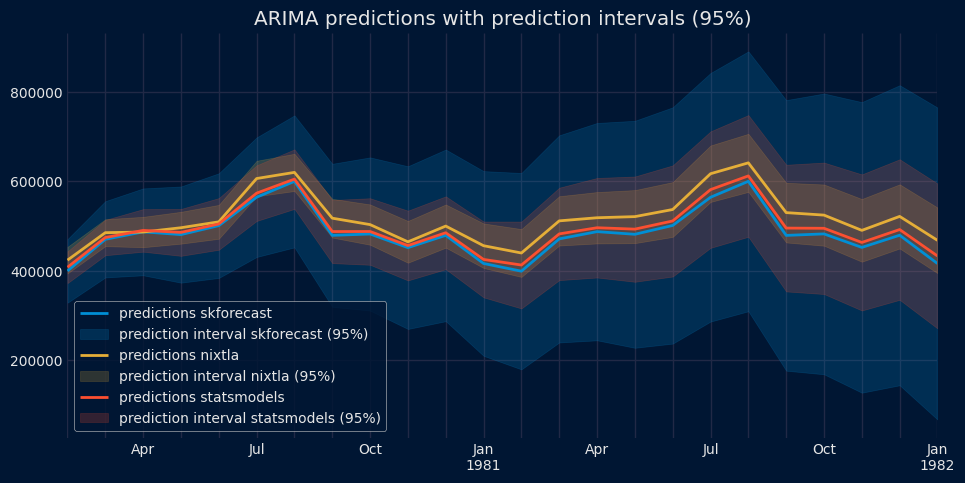

In [35]:
# Plot predictions with prediction intervals
# ======================================================================================
fig, ax = plt.subplots(figsize=(10, 5))

# Skforecast
predictions_skforecast.plot(ax=ax, label='predictions skforecast', color='C0', linewidth=2)
ax.fill_between(
    prediction_intervals_skforecast.index,
    prediction_intervals_skforecast['lower_bound'],
    prediction_intervals_skforecast['upper_bound'],
    color='C0',
    alpha=0.2,
    label='prediction interval skforecast (95%)'
)

# Nixtla
predictions_nixtla.plot(ax=ax, label='predictions nixtla', color='C2', linewidth=2)
ax.fill_between(
    prediction_intervals_nixtla.index,
    prediction_intervals_nixtla['lower_bound'],
    prediction_intervals_nixtla['upper_bound'],
    color='C2',
    alpha=0.2,
    label='prediction interval nixtla (95%)'
)

# Statsmodels
predictions_statsmodels.plot(ax=ax, label='predictions statsmodels', color='C1', linewidth=2)
ax.fill_between(
    prediction_intervals_statsmodels.index,
    prediction_intervals_statsmodels['lower_bound'],
    prediction_intervals_statsmodels['upper_bound'],
    color='C1',
    alpha=0.2,
    label='prediction interval statsmodels (95%)'
)

ax.set_title('ARIMA predictions with prediction intervals (95%)')
ax.legend();

In [72]:
# Compare prediction interval widths
# ======================================================================================
interval_widths = pd.DataFrame({
    'skforecast': prediction_intervals_skforecast['upper_bound'] - prediction_intervals_skforecast['lower_bound'],
    'nixtla': prediction_intervals_nixtla['upper_bound'] - prediction_intervals_nixtla['lower_bound'],
    'statsmodels': prediction_intervals_statsmodels['upper_bound'] - prediction_intervals_statsmodels['lower_bound']
})

print("\nPrediction Interval Widths Summary (95% confidence):")
print("=" * 60)
print(interval_widths.describe().T[['mean', 'std', 'min', 'max']])
print("\nAverage interval width:")
print(interval_widths.mean().sort_values())


Prediction Interval Widths Summary (95% confidence):
                      mean            std            min            max
skforecast   423494.720366  170380.112985  142404.526319  698143.913639
nixtla       104056.786062   27454.418516   59632.119240  146852.883404
statsmodels  194461.829430   79788.688584   71108.703733  324269.241785

Average interval width:
nixtla         104056.786062
statsmodels    194461.829430
skforecast     423494.720366
dtype: float64


In [37]:
# Backtesting ForecasterStats with Arima skforecast
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True,
        fixed_train_size   = False,
)
forecaster = ForecasterStats(
                 estimator=Arima(
                     order=order,
                     seasonal_order=seasonal_order,
                     m=m
                 )
             )

start = timeit.default_timer()
metric_arima_skforecast, pred_arima_skforecast = backtesting_stats(
    forecaster = forecaster,
    y          = data['y'],
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_arima_skforecast = stop - start

AttributeError: 'ForecasterStats' object has no attribute 'estimator'

In [82]:
# Backtesting ForecasterStats Arima aeon
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True,
        fixed_train_size   = False,
)
forecaster = ForecasterStats(
                 estimator=ARIMA_aeon(p=order[0], d=order[1], q=order[2])
             )

start = timeit.default_timer()
metric_arima_aeon, pred_arima_aeon = backtesting_stats(
    forecaster = forecaster,
    y          = data['y'],
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_arima_aeon = stop - start

  0%|          | 0/10 [00:00<?, ?it/s]

In [83]:
# Backtesting ForecasterStats Arima statsmodels
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True,
        fixed_train_size   = False,
)
forecaster = ForecasterStats(
                 estimator=Sarimax(order=order, seasonal_order=seasonal_order_statsmodels)
             )

start = timeit.default_timer()
metric_arima_statsmodels, pred_arima_statsmodels = backtesting_stats(
    forecaster = forecaster,
    y          = data['y'],
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_arima_statsmodels = stop - start

  0%|          | 0/10 [00:00<?, ?it/s]

In [75]:
# Backtesting ForecasterStats with ETS nixtla
# ==============================================================================
# Note: Nixtla's StatsForecast doesn't integrate directly with skforecast's backtesting
# For a fair comparison, we would need to implement custom backtesting for nixtla
print("Note: Nixtla StatsForecast backtesting would require custom implementation")

Note: Nixtla StatsForecast backtesting would require custom implementation


In [84]:
# Results
# ==============================================================================
results = pd.DataFrame(
    {
        "Model": [
            "Arima skforecast",
            "Arima aeon",
            "Arima statsmodels",
        ],
        "MAE": [
            
            metric_arima_skforecast.at[0, "mean_absolute_error"],
            metric_arima_aeon.at[0, "mean_absolute_error"],
            metric_arima_statsmodels.at[0, "mean_absolute_error"],
        ],
        "Elapsed Time (s)": [
            elapsed_time_arima_skforecast,
            elapsed_time_arima_aeon,
            elapsed_time_arima_statsmodels,
        ],
    }
)
results = results.sort_values(by="MAE").reset_index(drop=True)
results

,Model,MAE,Elapsed Time (s)
0,Arima statsmodels,19611.236352,6.898607
1,Arima skforecast,21565.341065,2.962212
2,Arima aeon,52780.282259,0.041681


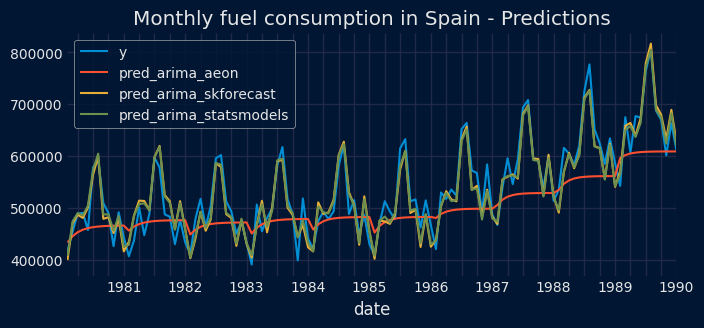

In [86]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data['y'].loc[data_test.index].plot(ax=ax, label='y')
pred_arima_aeon['pred'].plot(ax=ax, label='pred_arima_aeon')
pred_arima_skforecast['pred'].plot(ax=ax, label='pred_arima_skforecast')
pred_arima_statsmodels['pred'].plot(ax=ax, label='pred_arima_statsmodels')
ax.set_title('Monthly fuel consumption in Spain - Predictions')
ax.legend();